<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/Ataques_adversarios(Redes_Neuronales).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np
!pip install tensorflow==1.14.0

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Using TensorFlow backend.


In [0]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [3]:
iv3 = InceptionV3()









96116736/96112376 [==============================] - 8s 0us/step


In [4]:
print(iv3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
from keras.preprocessing import image

In [0]:
# Cargar la imagen original
x = image.img_to_array(image.load_img("/gatito.jpg", target_size=(299,299)))
# Cambio de rango de 0-255 a -1-1
x /= 255
x -= 0.5
x *= 2

x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])

In [9]:
x.shape

(1, 299, 299, 3)

In [0]:
y = iv3.predict(x)

In [11]:
decode_predictions(y)

40960/35363 [==================================] - 0s 0us/step


[[('n02119789', 'kit_fox', 0.36600193),
  ('n02137549', 'mongoose', 0.1588326),
  ('n02120079', 'Arctic_fox', 0.06262806),
  ('n02127052', 'lynx', 0.052616894),
  ('n02124075', 'Egyptian_cat', 0.02552358)]]

## Ataques adversarios

In [17]:
## Crear imagen adulterada 

inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

target_class = 951 # 951 es el número que se corresponde con el limón, que es lo que vamos a hacer que el modelo prediga 

loss = out_layer[0, target_class]

grad = K.gradients(loss, inp_layer)[0]

optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad,loss])

adv = np.copy(x)

pert = 0.01

max_pert = x + 0.01
min_pert = x - 0.01

cost = 0.0

while cost < 0.95:
  gr, cost = optimize_gradient([adv, 0])

  adv += gr

  adv = np.clip(adv, min_pert, max_pert)
  adv = np.clip(adv, -1, 1)

  print("Lemon cost:", cost)

hacked_img = np.copy(adv)

Lemon cost: 0.0005604771
Lemon cost: 0.00073155365
Lemon cost: 0.00097326876
Lemon cost: 0.0013506714
Lemon cost: 0.0019832605
Lemon cost: 0.0031670271
Lemon cost: 0.005751956
Lemon cost: 0.0124833165
Lemon cost: 0.03561504
Lemon cost: 0.14278658
Lemon cost: 0.09443034
Lemon cost: 0.07159193
Lemon cost: 0.67088264
Lemon cost: 0.10787761
Lemon cost: 0.72946364
Lemon cost: 0.8951735
Lemon cost: 0.9879303


In [0]:
adv /= 2
adv += 0.5
adv *= 255

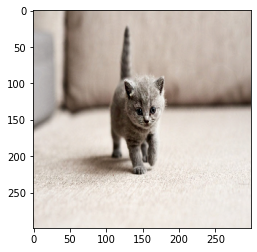

In [20]:
# Nueva imagen
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [0]:
# Guardar la imagen adulterada
 from PIL import Image
 im = Image.fromarray(adv[0].astype(np.uint8))
 im.save("/hacked.png")


In [24]:
# Utilizar el modelo sobre la imagen adulterada

x = image.img_to_array(image.load_img("/hacked.png", target_size=(299,299)))
# Cambio de rango de 0-255 a -1-1
x /= 255
x -= 0.5
x *= 2

x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])
y = iv3.predict(x)
decode_predictions(y)

[[('n07749582', 'lemon', 0.9966228),
  ('n07747607', 'orange', 0.0026330543),
  ('n04409515', 'tennis_ball', 9.069957e-05),
  ('n02777292', 'balance_beam', 4.150217e-05),
  ('n07742313', 'Granny_Smith', 3.1423082e-05)]]

Como podemos observar al utilizar el modelo sobre la nueva imagen adulterada, el modelo la clasifica
como un limón al 99.66%, siendo aparentemente la misma imagen que la original  